In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os



In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'e3c11603b207c8253d21825eae59c7bc'
os.environ["KAGGLE_USERNAME"] = 'gauravmanish834'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [3]:
#This code can be used to extract pretrained CNN (ResNet) Features.
#It takes Image Path and returns 2048-dimensional feature.
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features from an image
def extract_features(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = model(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    return features




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.6MB/s]


In [4]:
lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                # hog_feature = compute_hog(image)
                # lbp_feature = calcLBP(image)
                cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                cnn_feature = cnn_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(cnn_feature)
                y.append(folder_name)

In [5]:
X=np.array(X)
y=np.array(y)

In [6]:
X

array([[0.3022219 , 1.2219509 , 1.0873636 , ..., 0.01391251, 0.00546748,
        0.04980095],
       [0.31831384, 1.0770758 , 0.9595233 , ..., 0.01126874, 0.09945147,
        0.09393943],
       [0.6270991 , 0.9057119 , 1.3393751 , ..., 0.11219727, 0.14549728,
        0.32781637],
       ...,
       [0.00939134, 1.2791433 , 0.12896234, ..., 0.06339424, 0.05852752,
        0.01523724],
       [0.25665504, 1.1094645 , 0.88696   , ..., 0.20591348, 0.04892847,
        0.09953579],
       [0.06003762, 0.96624583, 0.52202356, ..., 0.32132375, 0.4699043 ,
        0.13750285]], dtype=float32)

In [7]:
y.shape

(1288,)

In [8]:
X.shape

(1288, 2048)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()
X_train=lda.fit_transform(X_train,y_train)
X_test=lda.transform(X_test)


# Fit the LDA model to the data


In [44]:
X_test.shape

(426, 6)

In [45]:
X_train.shape

(862, 6)

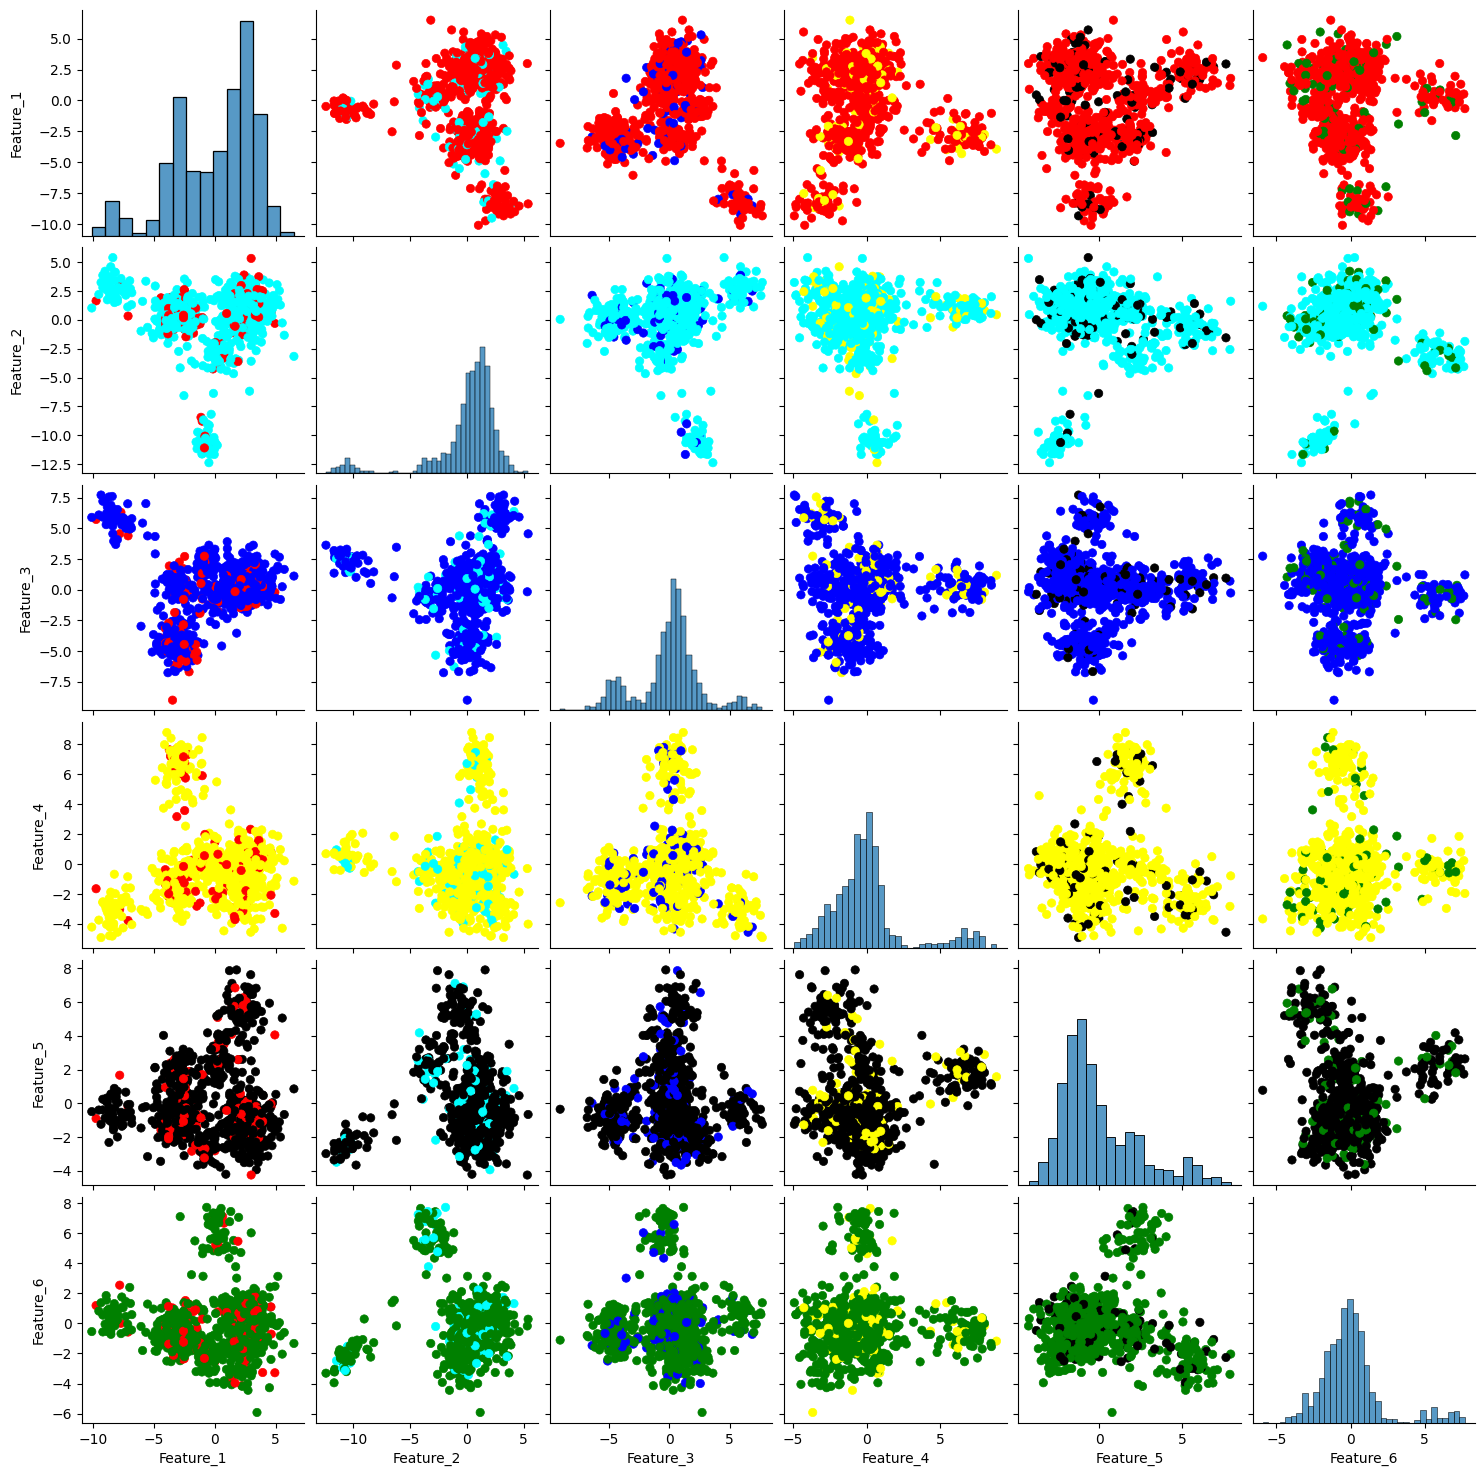

In [46]:
import seaborn as sns
import pandas as pd

# Convert X_train and y_train to a DataFrame
X_train_df = pd.DataFrame(X_train, columns=['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6'])
y_train_df = pd.DataFrame(y_train, columns=['Class'])

# Combine X_train and y_train into a single DataFrame
train_df = pd.concat([X_train_df, y_train_df], axis=1)

# Create pair plots
pairplot = sns.pairplot(train_df)

# Custom color mapping for each feature
color_map = {
    'Feature_1': 'red',
    'Feature_2': 'cyan',
    'Feature_3': 'blue',
    'Feature_4': 'yellow',
    'Feature_5': 'black',
    'Feature_6': 'green'
}

# Apply custom colors to each scatter plot
for i in range(pairplot.axes.shape[0]):
    for j in range(pairplot.axes.shape[1]):
        ax = pairplot.axes[i, j]
        if i != j:
            feature_x = ax.get_xlabel()
            feature_y = ax.get_ylabel()
            scatter_kws = {'color': [color_map[feature_x] if label == feature_x else color_map[feature_y] for label in train_df.columns]}
            ax.collections[0].set(**scatter_kws)

# Show the pair plot
pairplot


In [47]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()


In [69]:
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range ,)
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [70]:
y_pred=grid.predict(X_test)

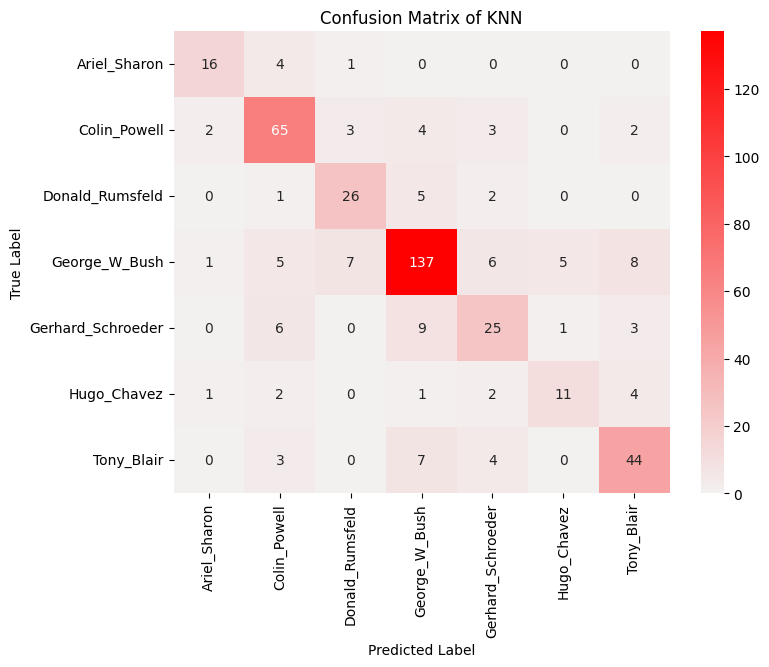

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of KNN')
plt.show()


In [72]:
nn=grid.best_params_

In [73]:
from sklearn.metrics import accuracy_score
print("accuracy score whith knn with n_neighbors=",nn['n_neighbors'],"(best case) is:",accuracy_score(y_test, y_pred))

accuracy score whith knn with n_neighbors= 1 (best case) is: 0.7652582159624414


In [74]:
from sklearn.linear_model import LogisticRegression

# Define logistic regression classifier
logistic_regression = LogisticRegression(max_iter=200)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
}

# Create GridSearchCV object
grid_logistic_regression = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# Fit the model to the training data
grid_logistic_regression.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

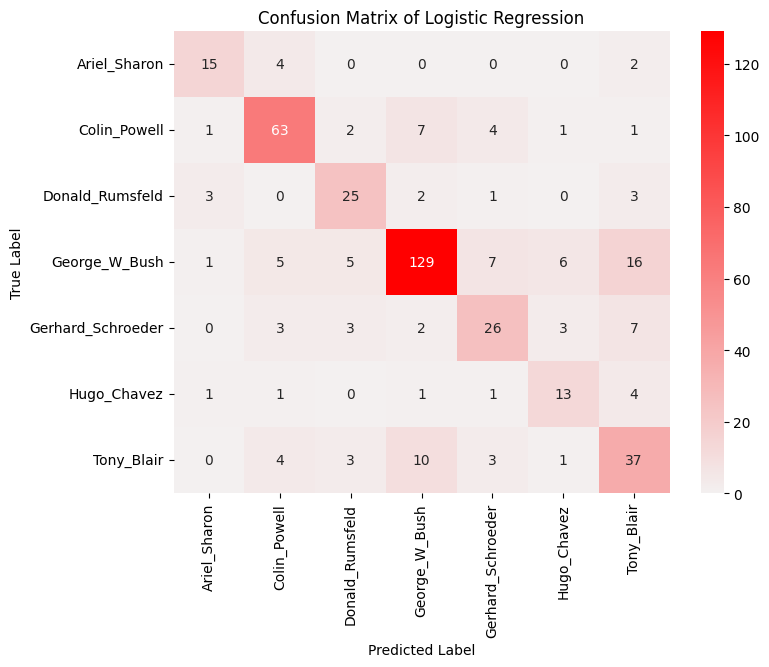

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
y_pred = grid_logistic_regression.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Logistic Regression')
plt.show()


In [54]:
# Print the best parameters and best score
print("Best parameters found: ", grid_logistic_regression.best_params_)
print("Best accuracy found: ", grid_logistic_regression.best_score_)

Best parameters found:  {'C': 10, 'penalty': 'l2'}
Best accuracy found:  0.9907110398289227


In [56]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=140,max_depth=60,min_samples_split=2,min_samples_leaf=5)
rf_classifier.fit(X_train,y_train)


0.7206572769953051


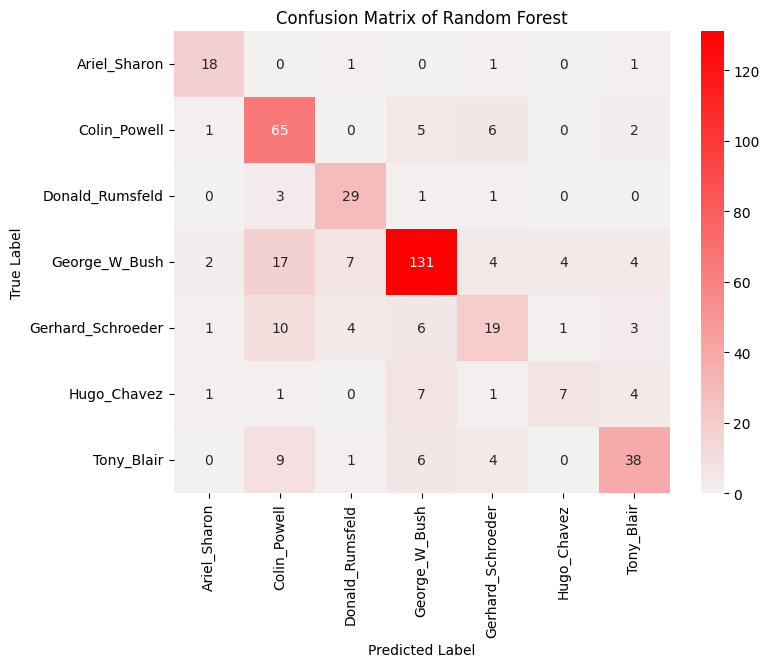

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
y_pred = rf_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Random Forest')
plt.show()


In [81]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.7206572769953051


In [83]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)


GaussianNB()

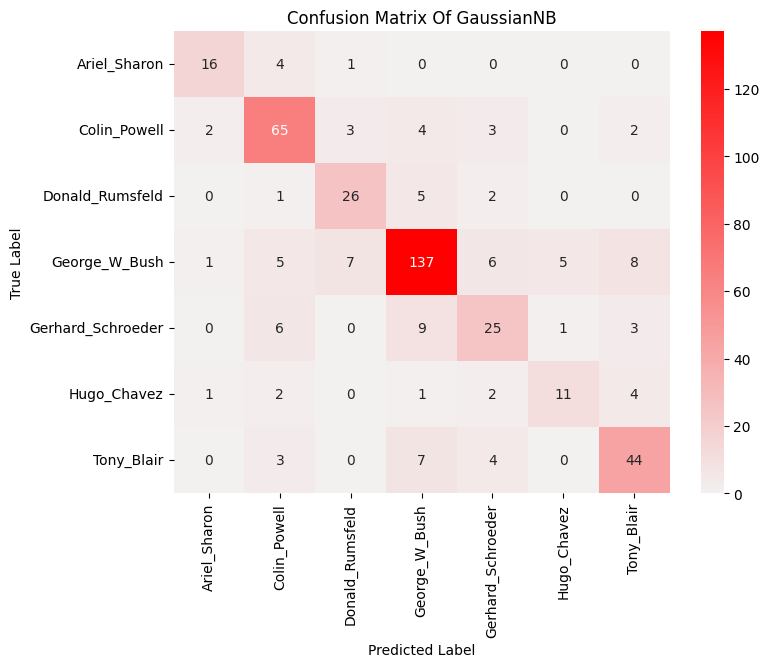

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
y_pred = gnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Of GaussianNB')
plt.show()


In [85]:
y_pred = gnb.predict(X_test)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 76.05633802816901


In [59]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Linear SVM
svm_linear = SVC(kernel='linear',C=1)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear))
print(accuracy_score(y_test,y_pred_linear))

Linear SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.75      0.86      0.80        21
     Colin_Powell       0.79      0.77      0.78        79
  Donald_Rumsfeld       0.53      0.71      0.61        34
    George_W_Bush       0.85      0.78      0.81       169
Gerhard_Schroeder       0.69      0.70      0.70        44
      Hugo_Chavez       0.62      0.71      0.67        21
       Tony_Blair       0.64      0.62      0.63        58

         accuracy                           0.74       426
        macro avg       0.70      0.74      0.71       426
     weighted avg       0.75      0.74      0.75       426

0.744131455399061


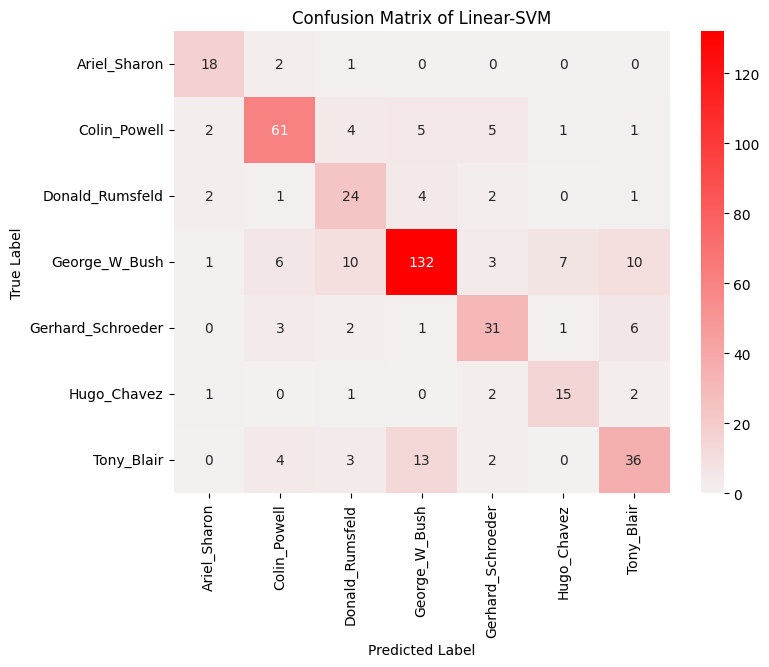

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_linear)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Linear-SVM')
plt.show()


In [61]:
# Polynomial SVM
svm_poly = SVC(kernel='poly', degree=2,C=1)  # You can adjust the degree parameter as needed
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("\nPolynomial SVM Classification Report:")
print(classification_report(y_test, y_pred_poly))
print(accuracy_score(y_test,y_pred_poly))


Polynomial SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.64      0.76      0.70        21
     Colin_Powell       0.64      0.47      0.54        79
  Donald_Rumsfeld       0.65      0.50      0.57        34
    George_W_Bush       0.58      0.76      0.66       169
Gerhard_Schroeder       0.63      0.39      0.48        44
      Hugo_Chavez       0.57      0.62      0.59        21
       Tony_Blair       0.74      0.59      0.65        58

         accuracy                           0.62       426
        macro avg       0.63      0.58      0.60       426
     weighted avg       0.63      0.62      0.61       426

0.6150234741784038


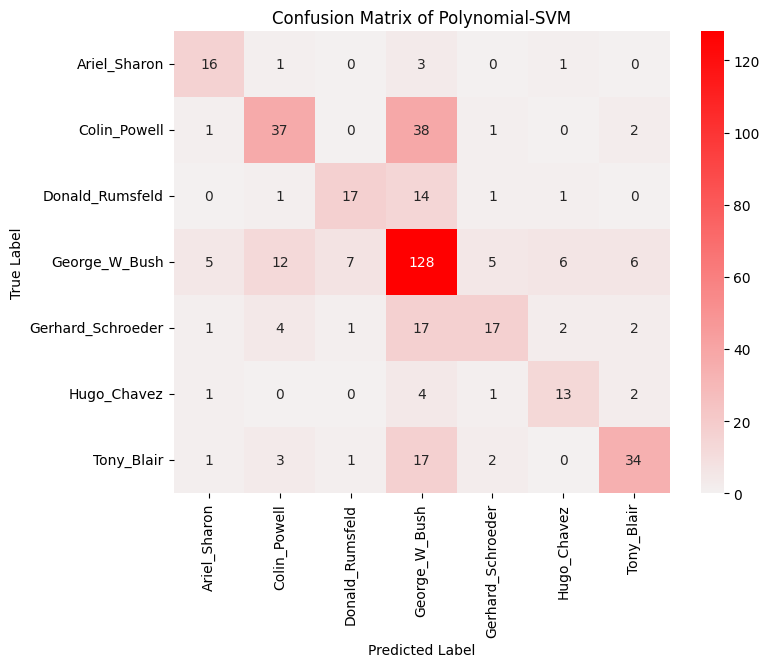

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
#y_pred = gnb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_poly)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Polynomial-SVM')
plt.show()


In [62]:
# RBF SVM
svm_rbf = SVC(kernel='rbf',C=100,gamma=0.001)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf))
print(accuracy_score(y_test,y_pred_rbf))


RBF SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.78      0.86      0.82        21
     Colin_Powell       0.79      0.81      0.80        79
  Donald_Rumsfeld       0.63      0.85      0.72        34
    George_W_Bush       0.88      0.79      0.83       169
Gerhard_Schroeder       0.65      0.68      0.67        44
      Hugo_Chavez       0.60      0.71      0.65        21
       Tony_Blair       0.73      0.66      0.69        58

         accuracy                           0.77       426
        macro avg       0.72      0.77      0.74       426
     weighted avg       0.78      0.77      0.77       426

0.7699530516431925


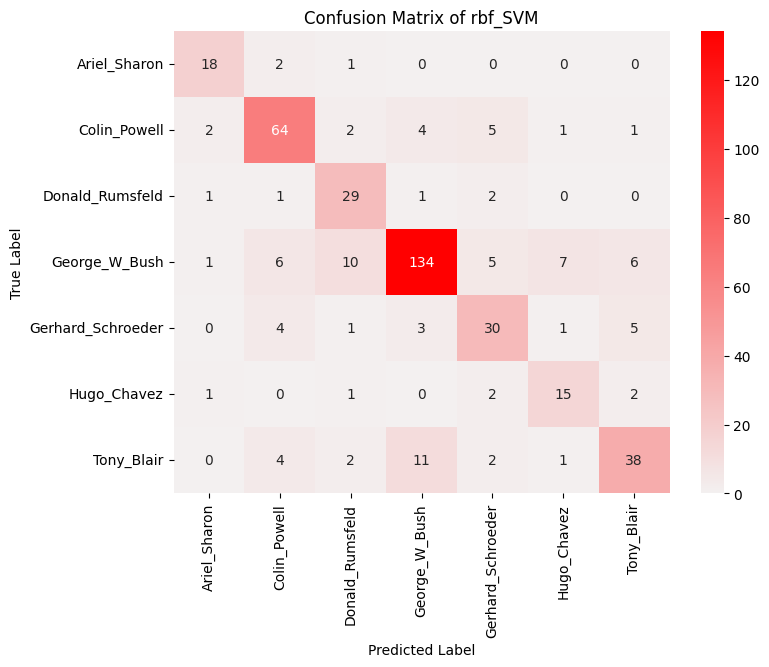

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rbf)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of rbf_SVM')
plt.show()


In [98]:
# Define parameter grids for each SVM kernel type
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'degree': [2, 3, 4],  # Polynomial degree
}

param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'gamma': [0.001, 0.01, 0.1, 1, 10]  # RBF kernel width
}

# Perform grid search for each SVM kernel type
grid_search_linear = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train, y_train)
print("Best parameters for Linear SVM:", grid_search_linear.best_params_)

grid_search_poly = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train, y_train)
print("Best parameters for Polynomial SVM:", grid_search_poly.best_params_)

grid_search_rbf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X_train, y_train)
print("Best parameters for RBF SVM:", grid_search_rbf.best_params_)

Best parameters for Linear SVM: {'C': 0.01}
Best parameters for Polynomial SVM: {'C': 100, 'degree': 3}
Best parameters for RBF SVM: {'C': 10, 'gamma': 0.001}


In [99]:
print("Accuracy for the best parameters for linear svm", accuracy_score(y_test,grid_search_linear.predict(X_test)))
print("Accuracy for the best parameters for polynomial svm", accuracy_score(y_test,grid_search_poly.predict(X_test)))
print("Accuracy for the best parameters for rbf svm", accuracy_score(y_test,grid_search_rbf.predict(X_test)))

Accuracy for the best parameters for linear svm 0.7769953051643192
Accuracy for the best parameters for polynomial svm 0.7230046948356808
Accuracy for the best parameters for rbf svm 0.7816901408450704


In [90]:
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(np.unique(y_train_encoded))

from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Convert predictions back to original labels


# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_mlp)
print("Accuracy:", accuracy)

from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, verbose=1,validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy:", accuracy)

[0 1 2 3 4 5 6]
Accuracy: 0.7676056338028169
Epoch 1/15
22/22 [==============================] - 1s 15ms/step - loss: 1.5656 - accuracy: 0.5965 - val_loss: 0.8833 - val_accuracy: 0.9769
Epoch 2/15
22/22 [==============================] - 0s 6ms/step - loss: 0.4852 - accuracy: 0.9840 - val_loss: 0.1828 - val_accuracy: 0.9827
Epoch 3/15
22/22 [==============================] - 0s 7ms/step - loss: 0.1057 - accuracy: 0.9869 - val_loss: 0.0653 - val_accuracy: 0.9827
Epoch 4/15
22/22 [==============================] - 0s 6ms/step - loss: 0.0495 - accuracy: 0.9927 - val_loss: 0.0534 - val_accuracy: 0.9769
Epoch 5/15
22/22 [==============================] - 0s 7ms/step - loss: 0.0354 - accuracy: 0.9927 - val_loss: 0.0459 - val_accuracy: 0.9827
Epoch 6/15
22/22 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9942 - val_loss: 0.0450 - val_accuracy: 0.9769
Epoch 7/15
22/22 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9942 - val_loss: 0.04

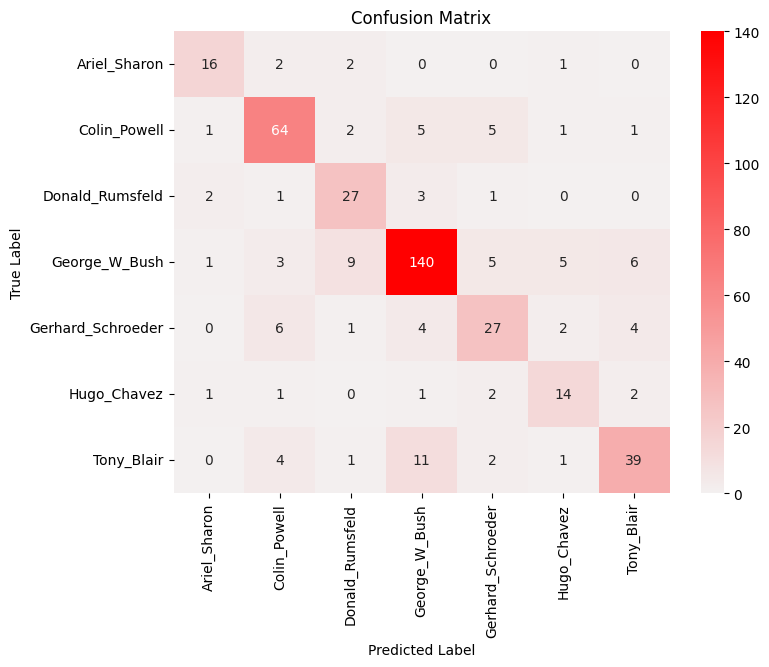

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix

conf_matrix = confusion_matrix(y_test_encoded, y_pred_mlp)
# Get the actual feature names
# Assuming you have a variable feature_names containing the feature names
# Replace feature_names with your actual feature names
feature_names = np.unique(y_test)

# Define a custom color palette
custom_palette = sns.light_palette("#FF0000", as_cmap=True)

# Plot confusion matrix heatmap with custom color palette
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=custom_palette, xticklabels=feature_names, yticklabels=feature_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:




# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     'n_estimators': range(1,200,10),
#     'max_depth': range(1,100,10),
#     'min_samples_split': [2],
#     'min_samples_leaf': range(1,50,10)
# }

# # Create Random Forest Classifier
# rf_classifier = RandomForestClassifier()

# # Perform grid search
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, Y_train)

# # Print best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)



